# Gene expression analysis with Gemini 3 (airway benchmark dataset)

This notebook uses a small **real RNA-seq benchmark dataset** (airway smooth muscle cells
treated with dexamethasone vs control) and then asks **Gemini 3** to summarize the
differential expression results.



In [1]:
# Install dependencies
!pip install --quiet google-genai pandas numpy scipy matplotlib

In [2]:
# Imports and Gemini client setup
import os, getpass
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from google import genai

# Get API key for Gemini (Developer API)
if 'GOOGLE_API_KEY' not in os.environ:
    os.environ['GOOGLE_API_KEY'] = getpass.getpass('Enter your Gemini API key: ')

GOOGLE_API_KEY = os.environ['GOOGLE_API_KEY']
client = genai.Client(api_key=GOOGLE_API_KEY)
print('Gemini client ready.')

Enter your Gemini API key: ··········
Gemini client ready.


In [3]:
# Load small benchmark RNA-seq dataset (airway) with robust fallbacks

def load_csv_with_fallback(primary_url, secondary_url=None, **read_csv_kwargs):
    """Try reading from primary URL; if it looks wrong or fails, try secondary.
    Treat a single HTML-like column (e.g. '<div align=center>') as a failed read.
    """
    last_err = None
    for url in [primary_url, secondary_url]:
        if url is None:
            continue
        try:
            df = pd.read_csv(url, **read_csv_kwargs)
            # Heuristic: if only one column and it looks like HTML, skip
            if df.shape[1] == 1 and any('<' in str(c) for c in df.columns):
                print(f"Warning: {url} looked like HTML, trying fallback...")
                last_err = ValueError("Got HTML instead of CSV")
                continue
            print(f"Loaded CSV from: {url}")
            return df
        except Exception as e:
            print(f"Failed to load {url}: {e}")
            last_err = e
    raise last_err if last_err is not None else RuntimeError("Failed to load CSV from any URL")

# Two mirrors that commonly host this dataset
counts_url_primary = "https://bioconnector.github.io/workshops/data/airway_scaledcounts.csv"
counts_url_secondary = "https://bdsr.stephenturner.us/data/airway_scaledcounts.csv"

meta_url_primary = "https://bioconnector.github.io/workshops/data/airway_metadata.csv"
meta_url_secondary = "https://bdsr.stephenturner.us/data/airway_metadata.csv"

counts = load_csv_with_fallback(counts_url_primary, counts_url_secondary)
metadata = load_csv_with_fallback(meta_url_primary, meta_url_secondary)

print('Counts shape (full):', counts.shape)
print('Metadata shape:', metadata.shape)
display(metadata.head())
counts.head()

Loaded CSV from: https://bioconnector.github.io/workshops/data/airway_scaledcounts.csv
Loaded CSV from: https://bioconnector.github.io/workshops/data/airway_metadata.csv
Counts shape (full): (38694, 9)
Metadata shape: (8, 4)


,id,dex,celltype,geo_id
0,SRR1039508,control,N61311,GSM1275862
1,SRR1039509,treated,N61311,GSM1275863
2,SRR1039512,control,N052611,GSM1275866
3,SRR1039513,treated,N052611,GSM1275867
4,SRR1039516,control,N080611,GSM1275870


,ensgene,SRR1039508,SRR1039509,SRR1039512,SRR1039513,SRR1039516,SRR1039517,SRR1039520,SRR1039521
0,ENSG00000000003,723.0,486.0,904.0,445.0,1170.0,1097.0,806.0,604.0
1,ENSG00000000005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ENSG00000000419,467.0,523.0,616.0,371.0,582.0,781.0,417.0,509.0
3,ENSG00000000457,347.0,258.0,364.0,237.0,318.0,447.0,330.0,324.0
4,ENSG00000000460,96.0,81.0,73.0,66.0,118.0,94.0,102.0,74.0


In [4]:
# Automatically detect gene ID column and build a smaller count matrix

possible_gene_cols = ["ensgene", "gene_id", "gene", "X"]
found_gene_col = None
for col in possible_gene_cols:
    if col in counts.columns:
        found_gene_col = col
        break

if found_gene_col is None:
    raise ValueError(
        f"No valid gene ID column found. Available columns: {list(counts.columns)}"
    )

print("Detected gene column:", found_gene_col)

# Subset to first 500 genes for speed and set index
counts_small = counts.iloc[:500].copy().set_index(found_gene_col)

# Ensure sample columns ordered to match metadata 'id'
sample_ids = metadata["id"].tolist()
counts_small = counts_small[sample_ids]

print("Counts (subset) shape:", counts_small.shape)
counts_small.head()

Detected gene column: ensgene
Counts (subset) shape: (500, 8)


,SRR1039508,SRR1039509,SRR1039512,SRR1039513,SRR1039516,SRR1039517,SRR1039520,SRR1039521
ensgene,,,,,,,,
ENSG00000000003,723.0,486.0,904.0,445.0,1170.0,1097.0,806.0,604.0
ENSG00000000005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000000419,467.0,523.0,616.0,371.0,582.0,781.0,417.0,509.0
ENSG00000000457,347.0,258.0,364.0,237.0,318.0,447.0,330.0,324.0
ENSG00000000460,96.0,81.0,73.0,66.0,118.0,94.0,102.0,74.0


In [5]:
# Split into control vs treated using metadata, robust to label variants

dex_vals = metadata['dex'].unique()
print('Unique dex labels:', dex_vals)

if 'control' in dex_vals:
    control_mask = metadata['dex'] == 'control'
elif 'untrt' in dex_vals:
    control_mask = metadata['dex'] == 'untrt'
else:
    # Fallback: treat the first level as control
    base = dex_vals[0]
    print('Using', base, 'as control level (fallback).')
    control_mask = metadata['dex'] == base

treated_mask = ~control_mask

control_samples = metadata.loc[control_mask, 'id'].tolist()
treated_samples = metadata.loc[treated_mask, 'id'].tolist()

print('Control samples:', control_samples)
print('Treated samples:', treated_samples)

ctrl_df = counts_small[control_samples]
trt_df = counts_small[treated_samples]
ctrl_df.head()

Unique dex labels: ['control' 'treated']
Control samples: ['SRR1039508', 'SRR1039512', 'SRR1039516', 'SRR1039520']
Treated samples: ['SRR1039509', 'SRR1039513', 'SRR1039517', 'SRR1039521']


,SRR1039508,SRR1039512,SRR1039516,SRR1039520
ensgene,,,,
ENSG00000000003,723.0,904.0,1170.0,806.0
ENSG00000000005,0.0,0.0,0.0,0.0
ENSG00000000419,467.0,616.0,582.0,417.0
ENSG00000000457,347.0,364.0,318.0,330.0
ENSG00000000460,96.0,73.0,118.0,102.0


In [6]:
# Simple differential expression analysis: log2FC + t-test

genes = counts_small.index.tolist()

mean_ctrl = ctrl_df.mean(axis=1)
mean_trt = trt_df.mean(axis=1)

# log2 fold change (treated vs control)
log2_fc = np.log2((mean_trt + 1e-6) / (mean_ctrl + 1e-6))

pvals = []
for g in genes:
    t_stat, p_val = stats.ttest_ind(trt_df.loc[g], ctrl_df.loc[g], equal_var=False)
    pvals.append(p_val)

res = pd.DataFrame({
    'gene': genes,
    'mean_ctrl': mean_ctrl.values,
    'mean_trt': mean_trt.values,
    'log2_FC': log2_fc.values,
    'p_value': pvals,
})

# Simple Bonferroni correction (for illustration only)
res['p_adj'] = res['p_value'] * len(res)
res_sorted = res.sort_values('p_value')
res_sorted.head()

,gene,mean_ctrl,mean_trt,log2_FC,p_value,p_adj
328,ENSG00000013297,5568.00,1514.75,-1.878080,0.000419,0.209523
33,ENSG00000003096,581.25,268.25,-1.115581,0.000453,0.226319
308,ENSG00000011677,0.50,2.25,2.169923,0.003958,1.978792
62,ENSG00000004838,23.00,11.00,-1.064130,0.005260,2.629908
309,ENSG00000012048,378.50,129.25,-1.550129,0.005981,2.990390


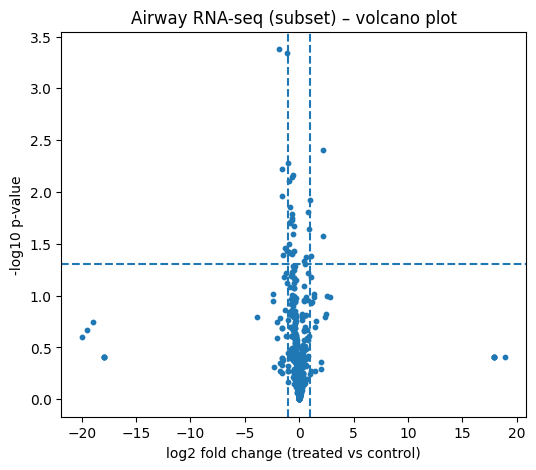

In [7]:
# Volcano plot

plt.figure(figsize=(6, 5))
plt.scatter(res['log2_FC'], -np.log10(res['p_value']), s=10)
plt.axvline(1.0, linestyle='--')
plt.axvline(-1.0, linestyle='--')
plt.axhline(-np.log10(0.05), linestyle='--')
plt.xlabel('log2 fold change (treated vs control)')
plt.ylabel('-log10 p-value')
plt.title('Airway RNA-seq (subset) – volcano plot')
plt.show()

In [8]:
# Select top up/down-regulated genes

log2fc_thresh = 1.0
p_thresh = 0.05

up = res[(res['log2_FC'] > log2fc_thresh) & (res['p_value'] < p_thresh)]
down = res[(res['log2_FC'] < -log2fc_thresh) & (res['p_value'] < p_thresh)]

print('Top up-regulated genes:')
display(up.sort_values('p_value').head(10))

print('\nTop down-regulated genes:')
display(down.sort_values('p_value').head(10))

Top up-regulated genes:


,gene,mean_ctrl,mean_trt,log2_FC,p_value,p_adj
308,ENSG00000011677,0.5,2.25,2.169923,0.003958,1.978792
364,ENSG00000015592,0.5,2.25,2.169923,0.026465,13.232683
401,ENSG00000020577,2014.0,4303.50,1.095447,0.041713,20.856731



Top down-regulated genes:


,gene,mean_ctrl,mean_trt,log2_FC,p_value,p_adj
328,ENSG00000013297,5568.00,1514.75,-1.878080,0.000419,0.209523
33,ENSG00000003096,581.25,268.25,-1.115581,0.000453,0.226319
62,ENSG00000004838,23.00,11.00,-1.064130,0.005260,2.629908
309,ENSG00000012048,378.50,129.25,-1.550129,0.005981,2.990390
327,ENSG00000013293,376.75,122.00,-1.626726,0.010975,5.487378
367,ENSG00000016391,155.00,62.25,-1.316122,0.034599,17.299551
394,ENSG00000019991,1773.50,832.00,-1.091944,0.037000,18.499893
368,ENSG00000016402,15.25,5.50,-1.471306,0.040483,20.241611


In [9]:
# Ask Gemini 3 to summarize the pattern using gemini-3-pro-preview

def df_to_md(df):
    if df.empty:
        return 'None'
    return df[['gene', 'log2_FC', 'p_value']].head(10).to_markdown(index=False)

if up.empty and down.empty:
    print('No genes passed the thresholds (|log2FC| >', log2fc_thresh,
          'and p <', p_thresh, ').')
    print('Try relaxing the thresholds (e.g., log2FC > 0.5 or p < 0.1).')
else:
    up_md = df_to_md(up.sort_values('p_value'))
    down_md = df_to_md(down.sort_values('p_value'))

    prompt = f'''
You are an expert bioinformatics assistant.

I ran a simple differential gene expression analysis on the airway RNA-seq dataset
(human airway smooth muscle cells treated with dexamethasone vs control).

Here are the top up-regulated genes (treated vs control):
{up_md}

Here are the top down-regulated genes:
{down_md}

Please:
- Explain in 3-6 bullet points what this *kind* of pattern could mean in general biological terms.
- Use plain language suitable for a student who knows basic molecular biology.
- Treat gene symbols as placeholders; do NOT invent specific real pathways for these genes.
'''

    response = client.models.generate_content(
        model='gemini-3-pro-preview',
        contents=prompt,
    )
    print(response.text)

Based on the general pattern of this data—where a specific set of genes shows strong up-regulation and another set shows strong down-regulation—here is an explanation of what is biologically happening in the cells:

*   **Transcriptional Reprogramming:** The data shows that the drug (dexamethasone) is causing the cells to "switch gears." The cell isn't just speeding up or slowing down its metabolism globally; it is actively selecting specific genetic programs to turn on and others to turn off. This suggests the drug is acting as a signal that forces the cell to change its current job or function.
*   **Targeted Repression ("Putting on the Brakes"):** You have several genes with negative Log2 Fold Changes (e.g., -1.8). A Log2 Fold Change of -1 means the gene expression has been cut in half. A value of -1.8 implies the gene is being expressed at less than 30% of its normal level. Biologically, this suggests the drug is actively suppressing a specific pathway, likely stopping a process th